# Ensemble stats - Difference in (weighted) mean, std, max, min - historical and rcp45/rcp85

- Weighted means take into account the number of days in each month

In [1]:
# import libraries
from datetime import datetime, timezone
import climag.plot_stats as cstats
import importlib
import xarray as xr
import matplotlib.pyplot as plt
import climag.plot_configs as cplt
import glob
import itertools
import os
import sys
import numpy as np

In [2]:
season_list = ["DJF", "MAM", "JJA", "SON"]
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]
stat_list = ["mean", "std", "max", "min"]

In [3]:
importlib.reload(cstats)

<module 'climag.plot_stats' from '/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/climag/plot_stats.py'>

In [4]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.assign(prod=data["i_bm"] + data["h_bm"])

    data = data.drop_vars([
        "bm_gv", "bm_gr", "bm_dv", "bm_dr", "age_gv", "age_gr", "age_dv",
        "age_dr", "omd_gv", "omd_gr", "lai", "env", "wr", "aet",
        "sen_gv", "sen_gr", "abs_dv", "abs_dr", "c_bm",
        "bm", "pgro", "i_bm", "h_bm"
    ])

    return data

In [5]:
def generate_stats(stat, var, ensemble=True):
    eurocordex = {}
    hiresireland = {}

    for exp, model, dataset in itertools.product(
        exp_list, model_list, dataset_list
    ):
        # auto-rechunking may cause NotImplementedError with object dtype where it
        # will not be able to estimate the size in bytes of object data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data", "ModVege", dataset, exp, model,
                    f"*{dataset}*{model}*{exp}*.nc"
                )
            ),
            chunks=CHUNKS,
            decode_coords="all"
        )

        if dataset == "EURO-CORDEX":
            crs_eurocordex = ds.rio.crs
        else:
            crs_hiresireland = ds.rio.crs

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds = ds.convert_calendar("360_day", align_on="year")

        # remove spin-up year
        if exp == "historical":
            ds = ds.sel(time=slice("1976", "2005"))
        else:
            ds = ds.sel(time=slice("2041", "2070"))

        # assign new coordinates and dimensions
        ds = ds.assign_coords(exp=exp)
        ds = ds.expand_dims(dim="exp")
        ds = ds.assign_coords(model=model)
        ds = ds.expand_dims(dim="model")

        # drop unnecessary variables
        ds = keep_minimal_vars(data=ds)

        # mean
        if stat == "mean":
            # weighted mean growth
            if var == "gro":
                ds_1 = ds.drop_vars(["prod"])
                # calculate the weights by grouping month length by season
                weights = (
                    ds_1["time"].dt.days_in_month.groupby("time.season") /
                    ds_1["time"].dt.days_in_month.groupby("time.season").sum()
                )
                # test that the sum of weights for each season is one
                np.testing.assert_allclose(
                    weights.groupby("time.season").sum().values,
                    np.ones(len(set(weights["season"].values)))
                )
                # calculate the weighted average
                ds_1 = (
                    (ds_1 * weights).groupby("time.season").sum(dim="time")
                )
                if ensemble:
                    ds_1 = ds_1.mean(dim="model", skipna=True)
                # sort seasons in the correct order
                ds_1 = ds_1.reindex(season=season_list)
            # mean production
            elif var == "prod":
                ds_1 = ds.drop_vars(["gro"])
                ds_1 = ds_1.groupby("time.year").max(dim="time", skipna=True)
                if ensemble:
                    ds_1 = ds_1.mean(dim=["year", "model"], skipna=True)
                else:
                    ds_1 = ds_1.mean(dim=["year"], skipna=True)
        # standard deviation
        elif stat == "std":
            # growth
            if var == "gro":
                ds_1 = ds.drop_vars(["prod"])
                if ensemble:
                    ds_1 = ds_1.groupby("time.season").std(dim=["time", "model"], ddof=1)
                else:
                    ds_1 = ds_1.groupby("time.season").std(dim=["time"], ddof=1)
                # sort seasons in the correct order
                ds_1 = ds_1.reindex(season=season_list)
            elif var == "prod":
                ds_1 = ds.drop_vars(["gro"])
                ds_1 = ds_1.groupby("time.year").max(dim="time", skipna=True)
                if ensemble:
                    ds_1 = ds_1.std(dim=["year", "model"], skipna=True, ddof=1)
                else:
                    ds_1 = ds_1.std(dim=["year"], skipna=True, ddof=1)
        # maximum
        elif stat == "max":
            # growth
            if var == "gro":
                ds_1 = ds.drop_vars(["prod"])
                if ensemble:
                    ds_1 = ds_1.groupby("time.season").max(dim=["time", "model"])
                else:
                    ds_1 = ds_1.groupby("time.season").max(dim=["time"])
                # sort seasons in the correct order
                ds_1 = ds_1.reindex(season=season_list)
            elif var == "prod":
                ds_1 = ds.drop_vars(["gro"])
                ds_1 = ds_1.groupby("time.year").max(dim="time", skipna=True)
                if ensemble:
                    ds_1 = ds_1.max(dim=["year", "model"], skipna=True)
                else:
                    ds_1 = ds_1.max(dim=["year"], skipna=True)
        # minimum
        elif stat == "min":
            # growth
            if var == "gro":
                ds_1 = ds.drop_vars(["prod"])
                if ensemble:
                    ds_1 = ds_1.groupby("time.season").min(dim=["time", "model"])
                else:
                    ds_1 = ds_1.groupby("time.season").min(dim=["time"])
                # sort seasons in the correct order
                ds_1 = ds_1.reindex(season=season_list)
            elif var == "prod":
                ds_1 = ds.drop_vars(["gro"])
                ds_1 = ds_1.groupby("time.year").max(dim="time", skipna=True)
                if ensemble:
                    ds_1 = ds_1.min(dim=["year", "model"], skipna=True)
                else:
                    ds_1 = ds_1.min(dim=["year"], skipna=True)


        if dataset == "EURO-CORDEX":
            eurocordex[f"{dataset}_{model}_{exp}"] = ds_1.copy()
        else:
            hiresireland[f"{dataset}_{model}_{exp}"] = ds_1.copy()

    eurocordex = xr.combine_by_coords(eurocordex.values(), combine_attrs="override")
    eurocordex.rio.write_crs(crs_eurocordex, inplace=True)
    hiresireland = xr.combine_by_coords(hiresireland.values(), combine_attrs="override")
    hiresireland.rio.write_crs(crs_hiresireland, inplace=True)

    return eurocordex, hiresireland

            # if dataset == "EURO-CORDEX":
            #     gro_eurocordex[f"{dataset}_{model}_{exp}"] = ds_1.copy()
            # else:
            #     gro_mean_hiresireland[f"{dataset}_{model}_{exp}"] = ds_1.copy()

        # # standard deviation - growth
        # ds_1 = ds.drop_vars(["prod"])
        # ds_1 = ds_1.groupby("time.season").std(dim=["time", "model"], ddof=1)
        # if dataset == "EURO-CORDEX":
        #     gro_std_eurocordex[f"{dataset}_{model}_{exp}"] = ds_1.copy()
        # else:
        #     gro_std_hiresireland[f"{dataset}_{model}_{exp}"] = ds_1.copy()

        # # mean - production
        # ds_1 = ds.drop_vars(["gro"])
        # ds_1 = ds_1.groupby("time.year").max(dim="time", skipna=True)
        # ds_1 = ds_1.mean(dim="year", skipna=True)
        # if dataset == "EURO-CORDEX":
        #     prod_mean_eurocordex[f"{dataset}_{model}_{exp}"] = ds_1.copy()
        # else:
        #     prod_mean_hiresireland[f"{dataset}_{model}_{exp}"] = ds_1.copy()

        # # standard deviation - production
        # ds_1 = ds.drop_vars(["gro"])
        # ds_1 = ds_1.groupby("time.year").max(dim="time", skipna=True)
        # ds_1 = ds_1.std(dim="year", skipna=True, ddof=1)
        # if dataset == "EURO-CORDEX":
        #     prod_mean_eurocordex[f"{dataset}_{model}_{exp}"] = ds_1.copy()
        # else:
        #     prod_mean_hiresireland[f"{dataset}_{model}_{exp}"] = ds_1.copy()

In [13]:
def plot_diff(data, var, levels):
    fig = data[var].plot.contourf(
        x="rlon", y="rlat", col="season", row="exp",
        cmap="BrBG", extend="both", robust=True,
        levels=cstats.colorbar_levels(levels),
        subplot_kws={"projection": cplt.plot_projection},
        transform=cplt.rotated_pole_transform(data),
        xlim=(-1.775, 1.6),
        ylim=(-2.1, 2.1),
        figsize=(12, 9.25),
        cbar_kwargs = {
            "label": "Difference [kg DM ha⁻¹ day⁻¹]",
            "aspect": 30,
            "location": "bottom",
            "fraction": 0.085,
            "shrink": 0.85,
            "pad": 0.05,
            "extendfrac": "auto",
            "ticks": cstats.colorbar_ticks(levels)
        }
    )
    for axis in fig.axs.flat:
        cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
            ax=axis, edgecolor="darkslategrey", color="white",
            linewidth=.5
        )
    fig.set_titles("{value}", weight="semibold", fontsize=14)
    plt.show()

In [7]:
def calculate_diff(data):
    data_out = xr.combine_by_coords([
        (
            data.sel(exp="rcp45") - data.sel(exp="historical")
        ).assign_coords(exp="rcp45 - historical").expand_dims(dim="exp"),
        (
            data.sel(exp="rcp85") - data.sel(exp="historical")
        ).assign_coords(exp="rcp85 - historical").expand_dims(dim="exp")
    ])
    return data_out

## Mean growth

In [27]:
eurocordex, hiresireland = generate_stats("mean", "gro")
eurocordex_diff = calculate_diff(eurocordex)
hiresireland_diff = calculate_diff(hiresireland)

#### EURO-CORDEX

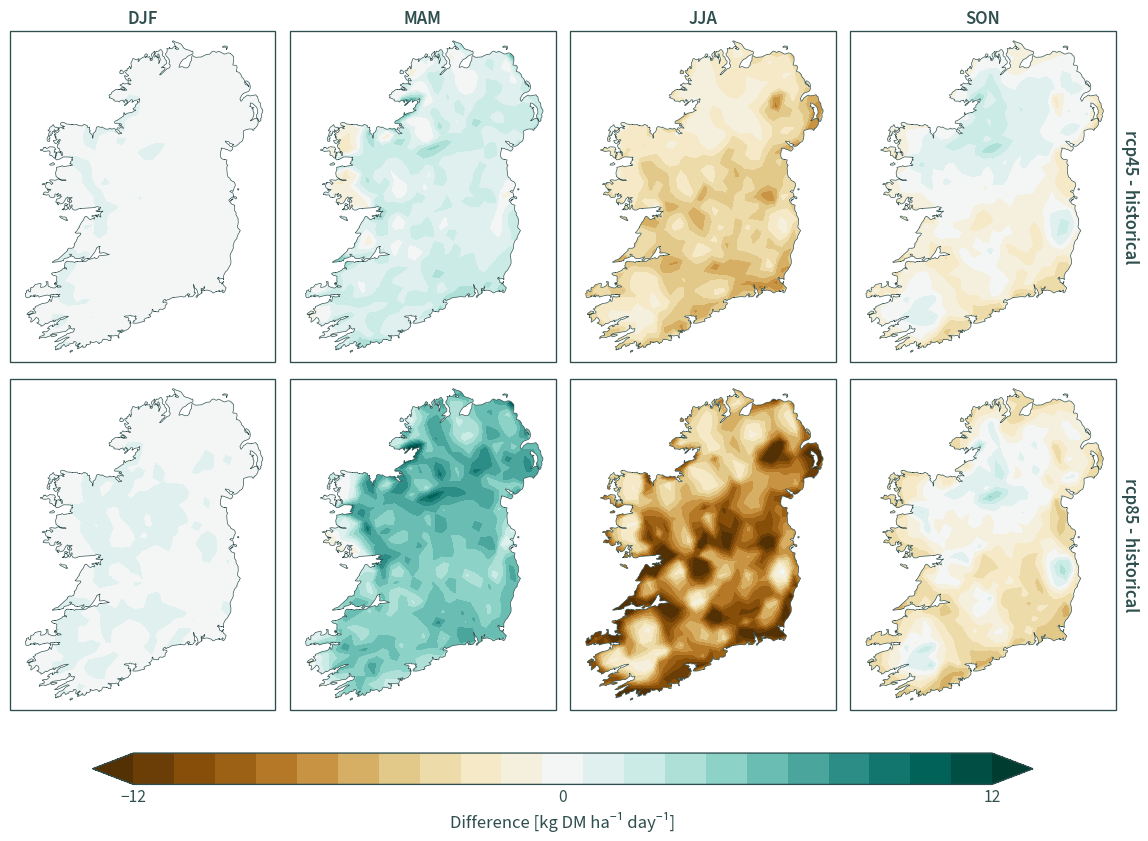

In [32]:
plot_diff(eurocordex_diff, "gro", 12)

#### HiResIreland

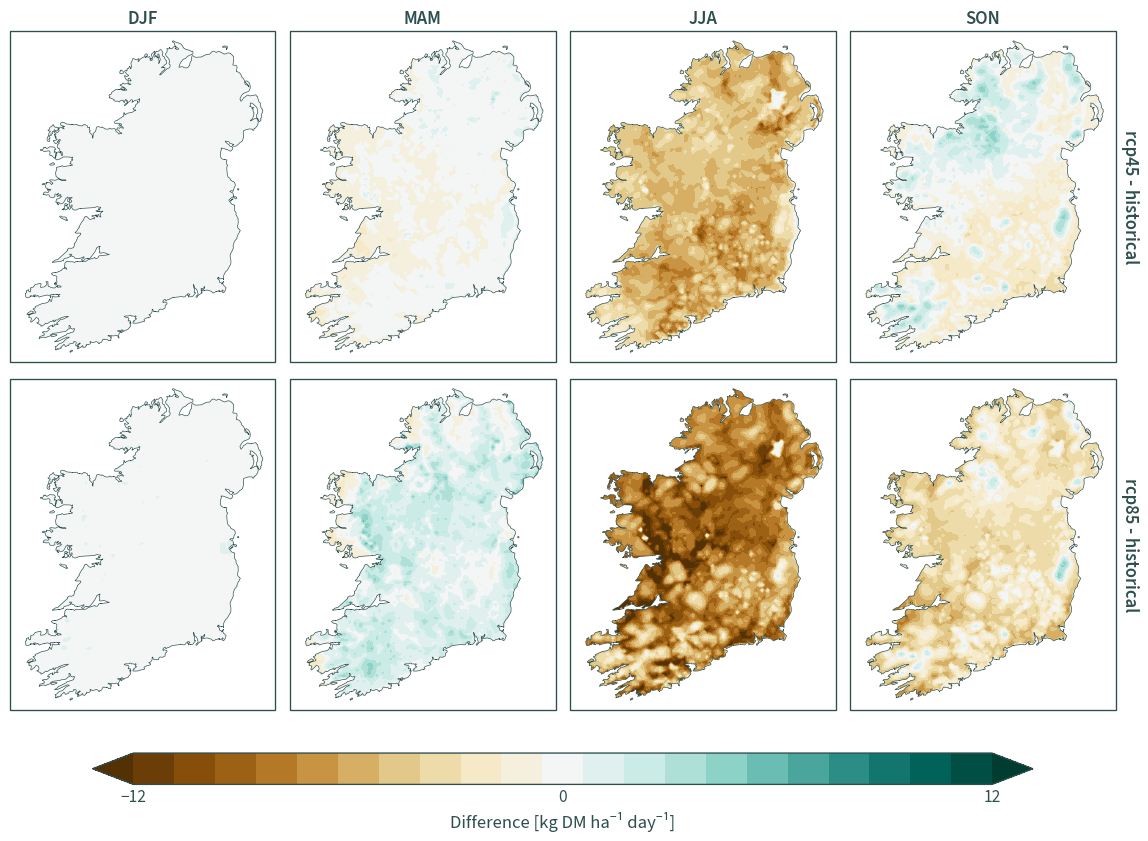

In [33]:
plot_diff(hiresireland_diff, "gro", 12)

## Standard deviation growth

In [18]:
eurocordex, hiresireland = generate_stats("std", "gro")
eurocordex_diff = calculate_diff(eurocordex)
hiresireland_diff = calculate_diff(hiresireland)

#### EURO-CORDEX

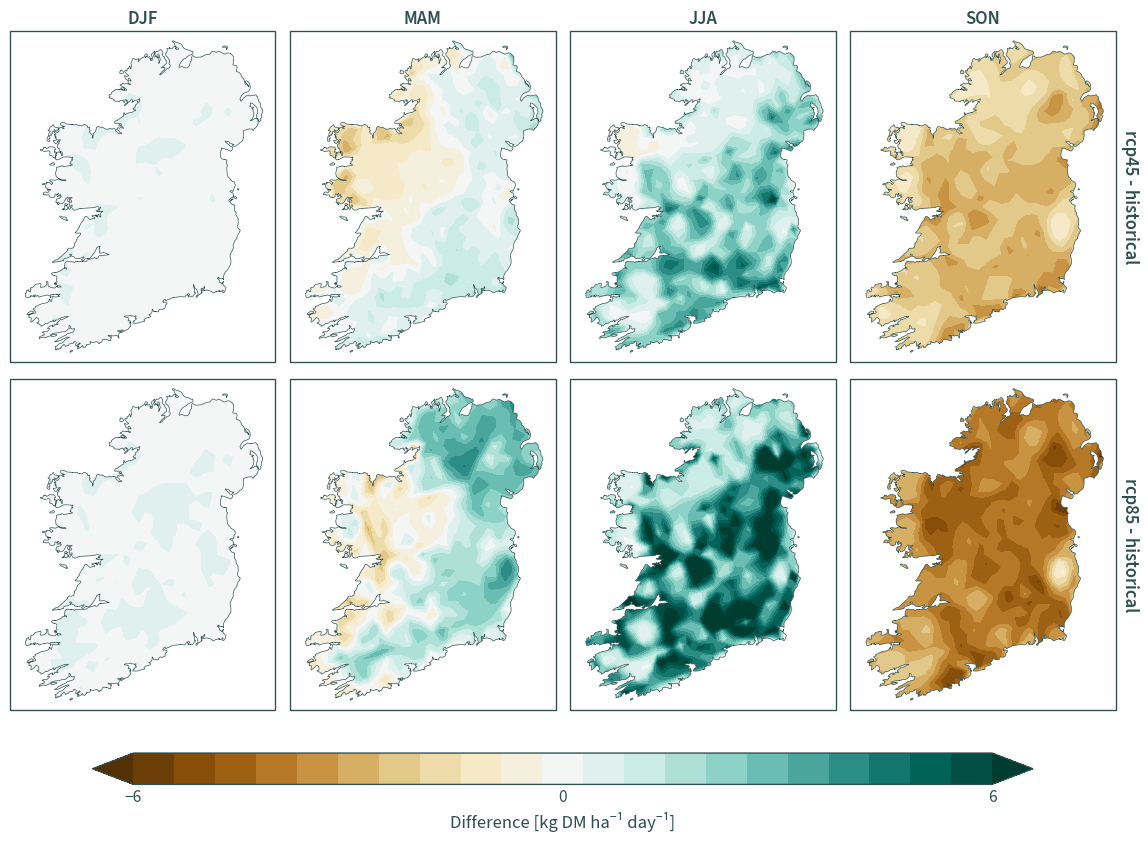

In [19]:
plot_diff(eurocordex_diff, "gro", 6)

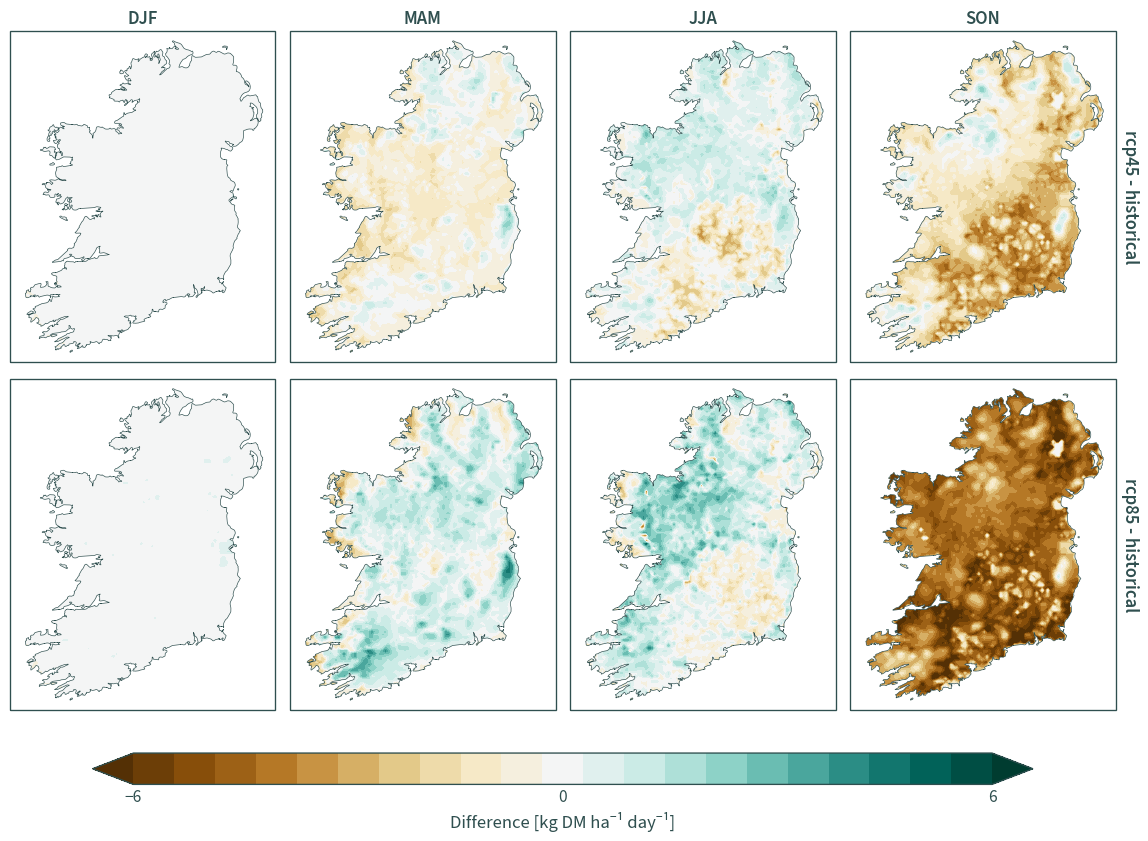

In [20]:
plot_diff(hiresireland_diff, "gro", 6)

## Maximum growth

In [25]:
eurocordex, hiresireland = generate_stats("max", "gro")
eurocordex_diff = calculate_diff(eurocordex)
hiresireland_diff = calculate_diff(hiresireland)

#### EURO-CORDEX

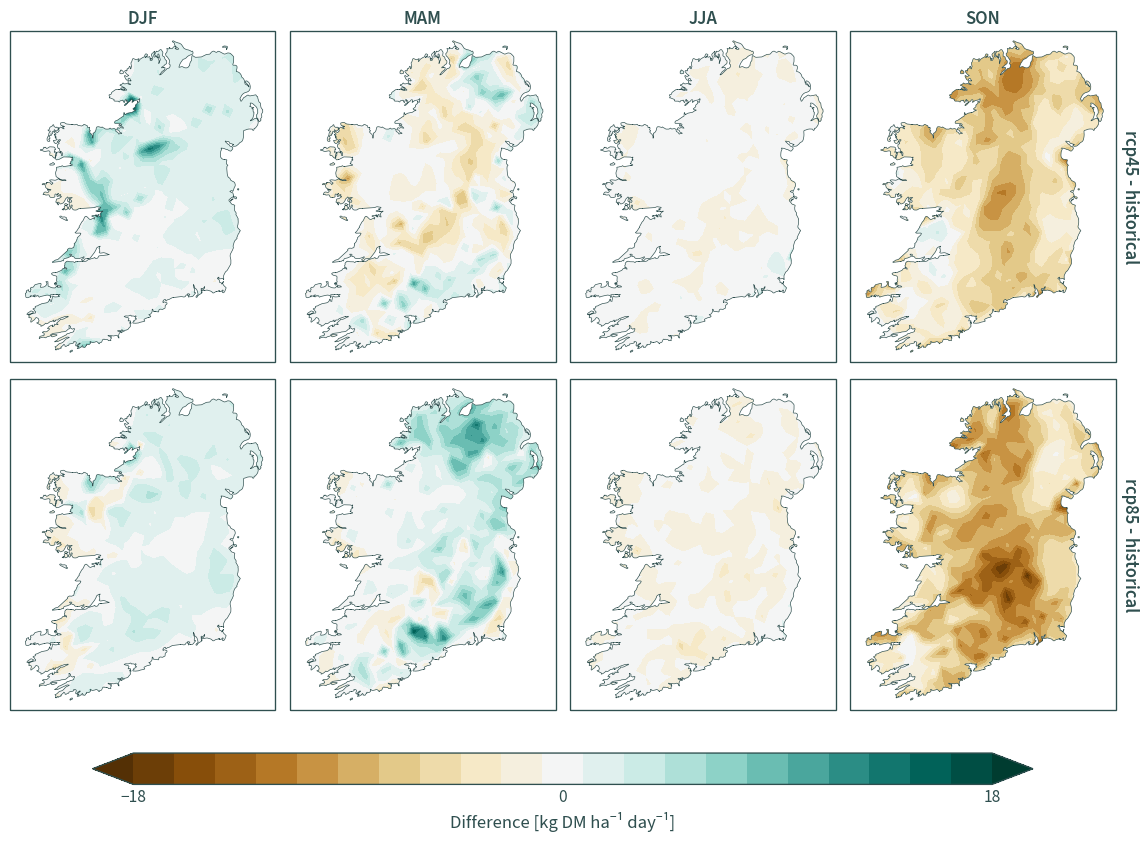

In [27]:
plot_diff(eurocordex_diff, "gro", 18)

#### HiResIreland

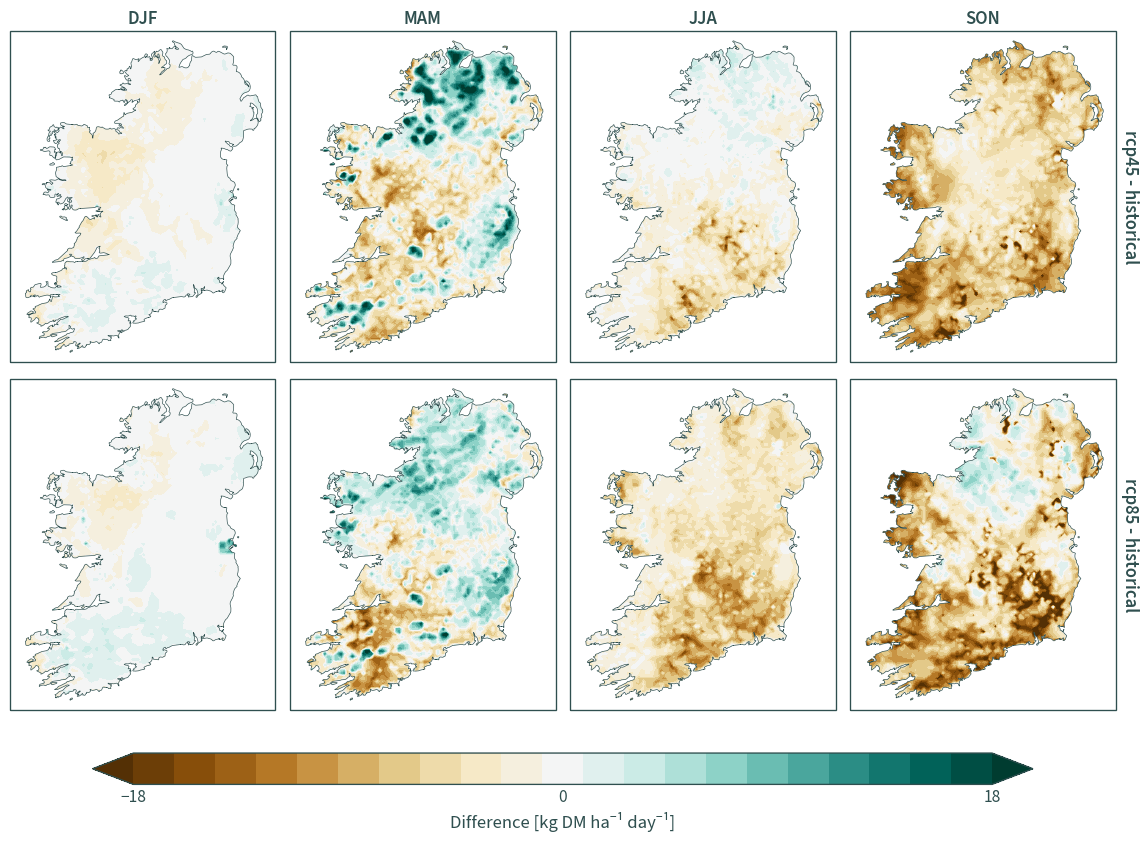

In [28]:
plot_diff(hiresireland_diff, "gro", 18)

## Minimum growth

In [35]:
eurocordex, hiresireland = generate_stats("min", "gro")
eurocordex_diff = calculate_diff(eurocordex)
hiresireland_diff = calculate_diff(hiresireland)

#### EURO-CORDEX

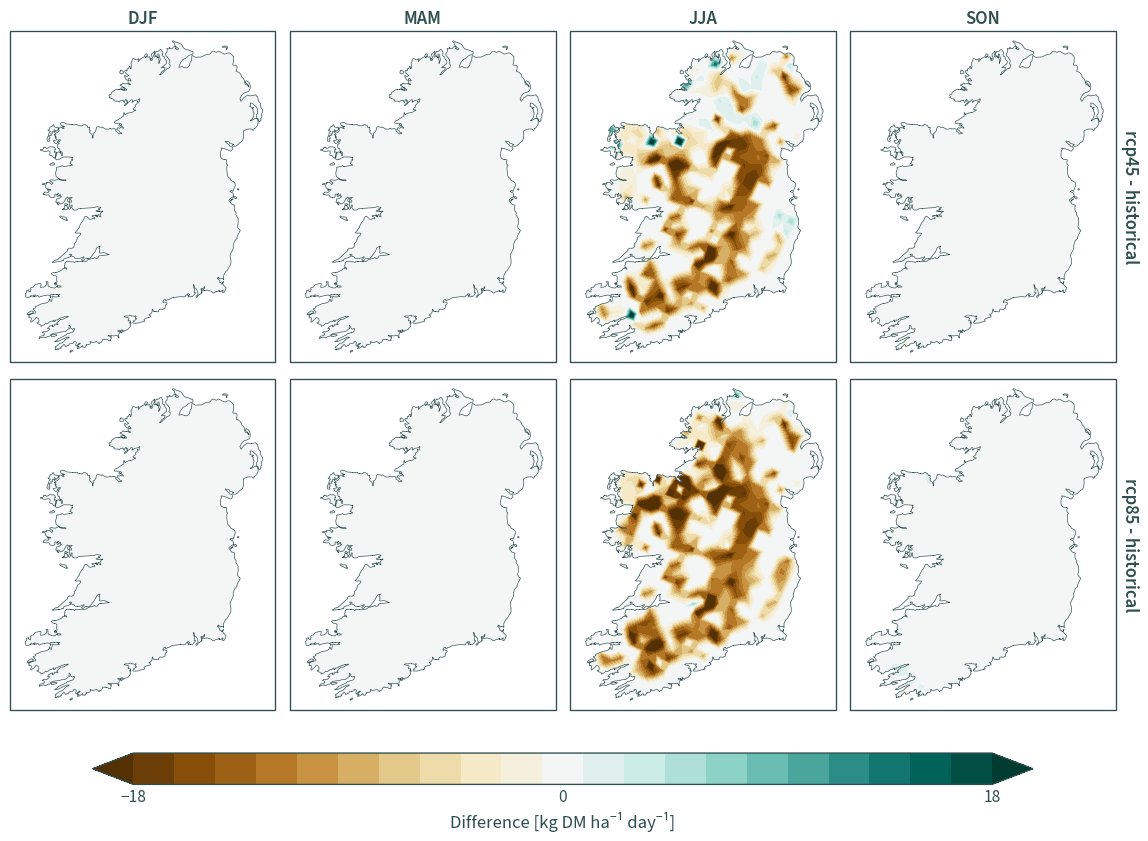

In [39]:
plot_diff(eurocordex_diff, "gro", 18)

#### HiResIreland

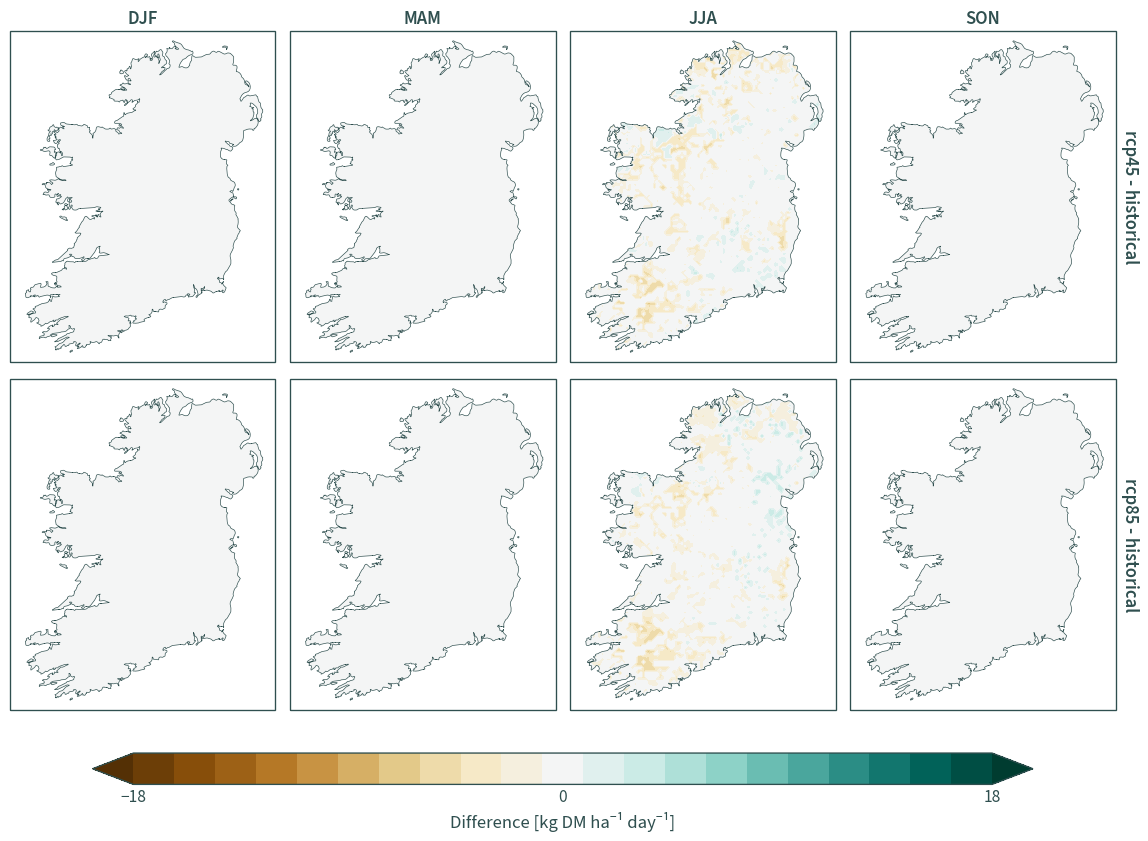

In [40]:
plot_diff(hiresireland_diff, "gro", 18)